# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=51b72a1281e8c8046a38b80c1a6f438f5dbd1ed6c0d09fd2cf4cb776804f7c9f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=76a4d4199914d4abc68321061df3703629c640ca1548f83589dbb83017fb2a30
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-7ivxozke
  Running command git clone --filter=blob:no

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 14.80 MiB/s, done.
Resolving deltas: 100% (3/3), done.


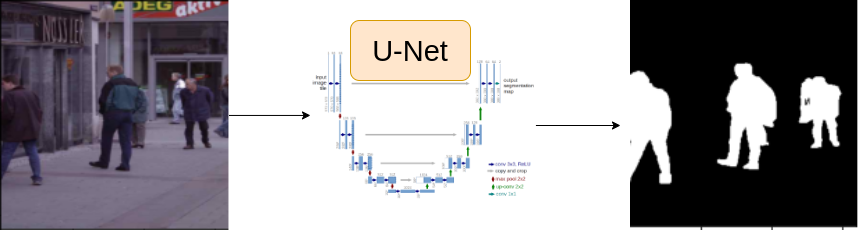

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import helper

import albumentations as A

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 50
LR = 0.001
IMAGE_SIZE = 224
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv('/content/Human-Segmentation-Dataset-master/train.csv')
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[50]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path) # image is read in BGR format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0 # convert BGR to RGB format

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

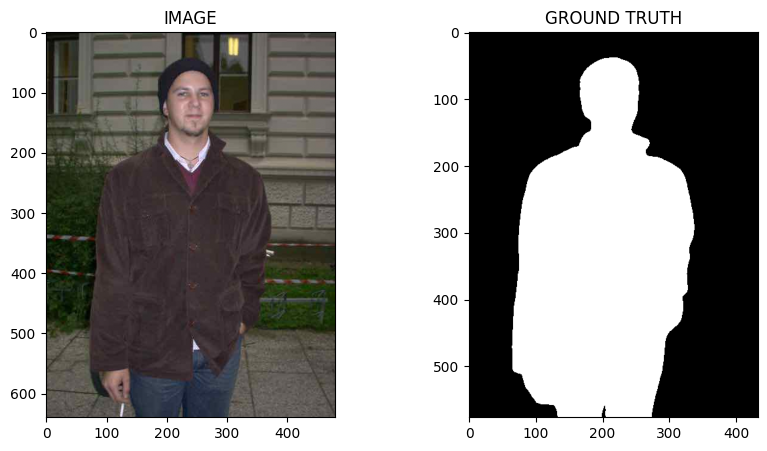

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(p = 0.5),
                    # A.VerticalFlip(p = 0.5),
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # format - (h, w)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0) # we rounded off soo that each pixel in the mask has a value of either 0 or 1

    return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


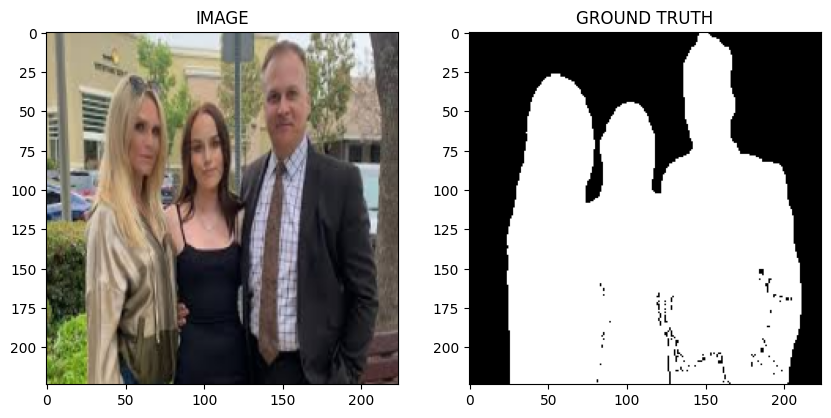

In [16]:
idx = 50

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [19]:
print(f'total number of batches in trainloader : {len(trainloader)}')
print(f'total number of batches in validloader : {len(validloader)}')

total number of batches in trainloader : 15
total number of batches in validloader : 4


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [20]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [21]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, mask = None):
    logits = self.arc(images)

    if mask != None:
      loss1 = DiceLoss(mode = 'binary')(logits, mask)
      loss2 = nn.BCEWithLogitsLoss()(logits, mask)
      return logits, loss1 + loss2

    return logits

In [22]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 66.4MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# Task 7 : Create Train and Validation Function

In [23]:
def train_fn(dataloader, model, optimizer):

  model.train()
  totalloss = 0

  for images, mask in tqdm(dataloader):
    images = images.to(DEVICE)
    mask = mask.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, mask)
    loss.backward()
    optimizer.step()

    totalloss += loss.item()

  return totalloss / len(dataloader) # average loss

In [24]:
def eval_fn(dataloader, model):

  model.eval()
  totalloss = 0

  with torch.no_grad():
    for images, mask in tqdm(dataloader):
      images = images.to(DEVICE)
      mask = mask.to(DEVICE)

      logits, loss = model(images, mask)

      totalloss += loss.item()

  return totalloss / len(dataloader) # average loss

# Task 8 : Train Model

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [26]:
best_valid_loss = np.Inf

for epoch in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("MODEL SAVED")
    best_valid_loss = valid_loss

  print(f'Epoch : {epoch+1} Train_loss : {train_loss} Valid_loss : {valid_loss}')
  scheduler.step()

100%|██████████| 4/4 [00:00<00:00,  8.01it/s]


MODEL SAVED
Epoch : 1 Train_loss : 0.9007105310757955 Valid_loss : 1.1402045488357544


100%|██████████| 4/4 [00:00<00:00,  7.03it/s]


MODEL SAVED
Epoch : 2 Train_loss : 0.39703116615613304 Valid_loss : 0.3803946450352669


100%|██████████| 4/4 [00:00<00:00,  8.65it/s]


MODEL SAVED
Epoch : 3 Train_loss : 0.29204371670881907 Valid_loss : 0.2398538626730442


100%|██████████| 4/4 [00:00<00:00,  8.71it/s]


Epoch : 4 Train_loss : 0.23451030751069388 Valid_loss : 0.3104171082377434


100%|██████████| 4/4 [00:00<00:00,  7.48it/s]


MODEL SAVED
Epoch : 5 Train_loss : 0.23779912193616232 Valid_loss : 0.21873367205262184


100%|██████████| 4/4 [00:00<00:00,  8.48it/s]


MODEL SAVED
Epoch : 6 Train_loss : 0.1724186529715856 Valid_loss : 0.18665294721722603


100%|██████████| 4/4 [00:00<00:00,  8.61it/s]


MODEL SAVED
Epoch : 7 Train_loss : 0.15946278870105743 Valid_loss : 0.18149952962994576


100%|██████████| 4/4 [00:00<00:00,  8.60it/s]


MODEL SAVED
Epoch : 8 Train_loss : 0.1485339974363645 Valid_loss : 0.18131311237812042


100%|██████████| 4/4 [00:00<00:00,  8.48it/s]


Epoch : 9 Train_loss : 0.14771790107091268 Valid_loss : 0.1871977113187313


100%|██████████| 4/4 [00:00<00:00,  8.58it/s]


Epoch : 10 Train_loss : 0.14390920251607894 Valid_loss : 0.18585632741451263


100%|██████████| 4/4 [00:00<00:00,  8.61it/s]


MODEL SAVED
Epoch : 11 Train_loss : 0.14689408044020336 Valid_loss : 0.18050184473395348


100%|██████████| 4/4 [00:00<00:00,  8.72it/s]


Epoch : 12 Train_loss : 0.14348966677983602 Valid_loss : 0.18179473280906677


100%|██████████| 4/4 [00:00<00:00,  8.90it/s]


Epoch : 13 Train_loss : 0.14547709474960963 Valid_loss : 0.18414056301116943


100%|██████████| 4/4 [00:00<00:00,  8.54it/s]


MODEL SAVED
Epoch : 14 Train_loss : 0.1504560813307762 Valid_loss : 0.18021101504564285


100%|██████████| 4/4 [00:00<00:00,  8.81it/s]


Epoch : 15 Train_loss : 0.13753342479467393 Valid_loss : 0.18238934502005577


100%|██████████| 4/4 [00:00<00:00,  8.75it/s]


MODEL SAVED
Epoch : 16 Train_loss : 0.1400929018855095 Valid_loss : 0.17980878055095673


100%|██████████| 4/4 [00:00<00:00,  8.82it/s]


MODEL SAVED
Epoch : 17 Train_loss : 0.14415189375480017 Valid_loss : 0.17890139669179916


100%|██████████| 4/4 [00:00<00:00,  8.63it/s]


Epoch : 18 Train_loss : 0.13480440725882847 Valid_loss : 0.17989256232976913


100%|██████████| 4/4 [00:00<00:00,  8.72it/s]


Epoch : 19 Train_loss : 0.13171380013227463 Valid_loss : 0.1800282523036003


100%|██████████| 4/4 [00:00<00:00,  8.94it/s]


Epoch : 20 Train_loss : 0.14662191420793533 Valid_loss : 0.18393560498952866


100%|██████████| 4/4 [00:00<00:00,  7.00it/s]


Epoch : 21 Train_loss : 0.1426619306206703 Valid_loss : 0.1807214729487896


100%|██████████| 4/4 [00:00<00:00,  8.74it/s]


MODEL SAVED
Epoch : 22 Train_loss : 0.1400667667388916 Valid_loss : 0.17765312269330025


100%|██████████| 4/4 [00:00<00:00,  8.87it/s]


Epoch : 23 Train_loss : 0.14723695516586305 Valid_loss : 0.17993280291557312


100%|██████████| 4/4 [00:00<00:00,  7.04it/s]


Epoch : 24 Train_loss : 0.13788924018541973 Valid_loss : 0.1825549639761448


100%|██████████| 4/4 [00:00<00:00,  9.06it/s]


Epoch : 25 Train_loss : 0.14526248673597972 Valid_loss : 0.1802976243197918


100%|██████████| 4/4 [00:00<00:00,  9.07it/s]


Epoch : 26 Train_loss : 0.14710877388715743 Valid_loss : 0.1792285293340683


100%|██████████| 4/4 [00:00<00:00,  7.30it/s]


Epoch : 27 Train_loss : 0.13588913182417553 Valid_loss : 0.1817658580839634


100%|██████████| 4/4 [00:00<00:00,  8.64it/s]


Epoch : 28 Train_loss : 0.145961960653464 Valid_loss : 0.17962485924363136


100%|██████████| 4/4 [00:00<00:00,  8.67it/s]


Epoch : 29 Train_loss : 0.13486325691143672 Valid_loss : 0.17988122627139091


100%|██████████| 4/4 [00:00<00:00,  6.77it/s]


Epoch : 30 Train_loss : 0.132948270936807 Valid_loss : 0.17953651398420334


100%|██████████| 4/4 [00:00<00:00,  8.94it/s]


Epoch : 31 Train_loss : 0.13590012689431508 Valid_loss : 0.17868858948349953


100%|██████████| 4/4 [00:00<00:00,  8.48it/s]


Epoch : 32 Train_loss : 0.13531610618034998 Valid_loss : 0.18062099069356918


100%|██████████| 4/4 [00:00<00:00,  7.14it/s]


Epoch : 33 Train_loss : 0.1372557411591212 Valid_loss : 0.1806877925992012


100%|██████████| 4/4 [00:00<00:00,  8.54it/s]


Epoch : 34 Train_loss : 0.14980285217364628 Valid_loss : 0.18060345575213432


100%|██████████| 4/4 [00:00<00:00,  8.93it/s]


Epoch : 35 Train_loss : 0.14160926242669422 Valid_loss : 0.18293748795986176


100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Epoch : 36 Train_loss : 0.13874776562054952 Valid_loss : 0.17916898429393768


100%|██████████| 4/4 [00:00<00:00,  9.08it/s]


Epoch : 37 Train_loss : 0.13055933465560277 Valid_loss : 0.17906084656715393


100%|██████████| 4/4 [00:00<00:00,  9.01it/s]


Epoch : 38 Train_loss : 0.15541996608177822 Valid_loss : 0.17913584411144257


100%|██████████| 4/4 [00:00<00:00,  8.91it/s]


Epoch : 39 Train_loss : 0.154241839547952 Valid_loss : 0.18047816306352615


100%|██████████| 4/4 [00:00<00:00,  8.91it/s]


Epoch : 40 Train_loss : 0.15272886504729588 Valid_loss : 0.18029621988534927


100%|██████████| 4/4 [00:00<00:00,  9.05it/s]


Epoch : 41 Train_loss : 0.12989499121904374 Valid_loss : 0.17943419143557549


100%|██████████| 4/4 [00:00<00:00,  8.92it/s]


Epoch : 42 Train_loss : 0.14112960447867712 Valid_loss : 0.17889641970396042


100%|██████████| 4/4 [00:00<00:00,  8.98it/s]


Epoch : 43 Train_loss : 0.13644726475079855 Valid_loss : 0.18296680599451065


100%|██████████| 4/4 [00:00<00:00,  8.81it/s]


Epoch : 44 Train_loss : 0.1344895154237747 Valid_loss : 0.17971063405275345


100%|██████████| 4/4 [00:00<00:00,  8.77it/s]


Epoch : 45 Train_loss : 0.1456499993801117 Valid_loss : 0.1797223947942257


100%|██████████| 4/4 [00:00<00:00,  7.47it/s]


Epoch : 46 Train_loss : 0.13307598233222961 Valid_loss : 0.17963312566280365


100%|██████████| 4/4 [00:00<00:00,  8.92it/s]


Epoch : 47 Train_loss : 0.13830351332823435 Valid_loss : 0.17956518009305


100%|██████████| 4/4 [00:00<00:00,  8.77it/s]


Epoch : 48 Train_loss : 0.14647269944349925 Valid_loss : 0.17907772585749626


100%|██████████| 4/4 [00:00<00:00,  6.85it/s]


Epoch : 49 Train_loss : 0.15156488368908563 Valid_loss : 0.17914697527885437


100%|██████████| 4/4 [00:00<00:00,  8.61it/s]

Epoch : 50 Train_loss : 0.13646005044380824 Valid_loss : 0.1790803000330925


# Task 9 : Inference

In [27]:
def calculate_iou(pred_mask, true_mask, threshold=0.5):

    pred_mask = (pred_mask > threshold).float()

    # Intersection and union
    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum(pred_mask) + torch.sum(true_mask) - intersection

    # Avoid division by zero
    if union == 0:
        return 1.0

    iou = intersection / union
    return iou.item()


In [31]:
def val_iou(dataloader, model):

    model.eval()
    total_iou = 0
    total_batches = len(dataloader)

    with torch.no_grad():
        for images, mask in tqdm(dataloader):
            images = images.to(DEVICE)
            mask = mask.to(DEVICE)

            # Forward pass
            logits, loss = model(images, mask)

            # Convert logits to predicted masks
            pred_mask = torch.sigmoid(logits)  # Assuming sigmoid for binary segmentation
            pred_mask = pred_mask.squeeze(1)  # Remove channel dimension

            # Calculate IoU for this batch
            batch_iou = calculate_iou(pred_mask, mask)
            total_iou += batch_iou

    avg_iou = total_iou / total_batches

    return avg_iou

In [32]:

model = SegmentationModel()
model.to(DEVICE)
model.load_state_dict(torch.load('/content/best_model.pt'))

avg_iou_score = val_iou(validloader, model)
print(f"\nAverage IoU Score: {avg_iou_score}")

<ipython-input-32-09115e8eb45c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))
100%|██████████| 4/4 [00:00<00:0


Average IoU Score: -1.4182555079460144


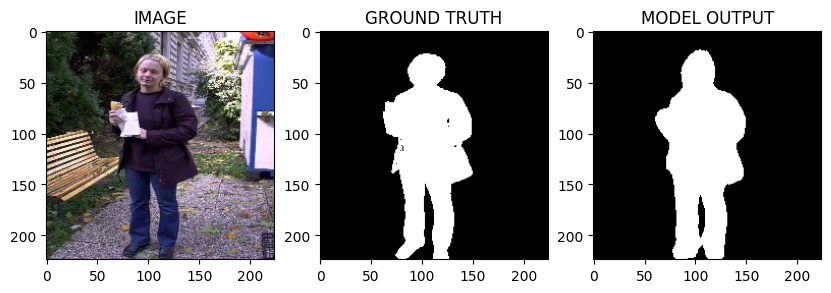

In [30]:
idx = 30

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # we unsqueeze to add 1 dim for channel - (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))